# KNN
Use K nearest neighbors for our regression problem.

In [39]:

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.preprocessing import minmax_scale
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

from get_metrics import write_metrics_in_csv

In [40]:
# Open dataset
filename: str = 'dataset.csv'
dataset = pd.read_pickle('dataRead_processed.pkl.bz2', compression='bz2')

# Split dataset
X = dataset.drop(columns=['total_passengers_2022'])
y = dataset['total_passengers_2022']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

dataset.dtypes

total_passengers_2022                        float64
total_passengers_2015                        float64
total_passengers_and_non_passengers_2015     float64
city_attraction_area                          object
city_category_in_attraction_area_2020        float64
department                                   float64
region                                       float64
sum_municipal_population_2021                float64
non_scholarized_15_years_old_or_more_2020    float64
main_residences_2020                         float64
housing_2020                                 float64
jobs_at_workplace_2020                       float64
hotels_2024_sum                              float64
camping_sites_2024_sum                       float64
other_tourist_accommodations_2024_sum        float64
latitude                                     float64
longitude                                    float64
passenger_growth_rate                        float64
attraction_density                           f

In [41]:
# Define common functions (metrics for instance)
def comptue_metrics(y_pred, y_real):
    r2 = r2_score(y_pred,y_real)
    mse = mean_squared_error(y_pred, y_real)
    median_abs_e = median_absolute_error(y_pred, y_real)
    mean_abs_e = mean_absolute_error(y_pred, y_real)
    return [r2, mse, median_abs_e, mean_abs_e]

In [42]:
# We also instantiate our results dataframe
results = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

def minimum_preprocessing(X, y):
    print('Original shape:{}'.format(X.shape))
    # Remove non numeric columns
    X = X.select_dtypes(include=[np.number])
    # We remove missing values
    X=X.dropna()
    y=y[X.index]
    # Normalize
    X = minmax_scale(X)
    print('New shape:{}'.format(X.shape))
    return X, y

X_train, y_train = minimum_preprocessing(X_train,y_train)
X_test, y_test = minimum_preprocessing(X_test,y_test)

Original shape:(1511, 36)
New shape:(1472, 35)
Original shape:(745, 36)
New shape:(724, 35)


,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
KNN,-,-,-,0.427753,417520546217.858398,77640.9,280685.896685


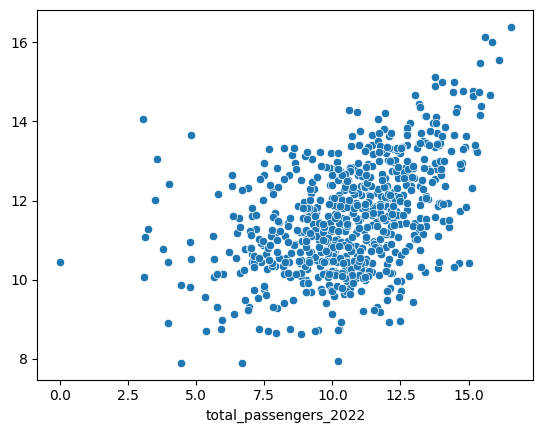

In [43]:
# Simple KNN model
knn = KNeighborsRegressor()

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

results.loc['KNN', :] = ['-', '-', '-'] + comptue_metrics(y_pred,y_test)

sns.scatterplot(x=np.log(y_test), y=np.log(y_pred))
results

## Parameter tuning: k of k nearest neighbors

In [44]:
# More complex model
train_score = {}
test_score = {}
n_neighbors = np.arange(1, 30, 1)

for neighbor in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_score[neighbor]=knn.score(X_train, y_train)
    test_score[neighbor]=knn.score(X_test, y_test)

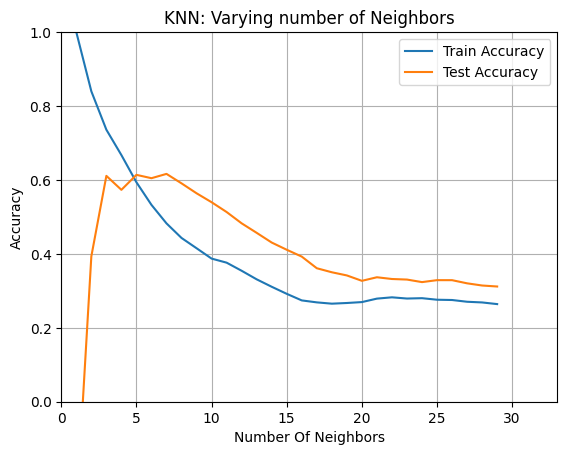

In [45]:
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, test_score.values(), label="Test Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, 33)
plt.ylim(0, 1)
plt.grid()
plt.show()

In [46]:
from sklearn.model_selection import KFold

# Parameter tuning
kf=KFold(n_splits=20,shuffle=True,random_state=42)
parameter={'n_neighbors': np.arange(2, 30, 1)}
knn=KNeighborsRegressor()
knn_cv=GridSearchCV(knn, param_grid=parameter, cv=kf, verbose=1)
knn_cv.fit(X_train, y_train)
print(knn_cv.best_params_)

Fitting 20 folds for each of 28 candidates, totalling 560 fits
{'n_neighbors': 2}


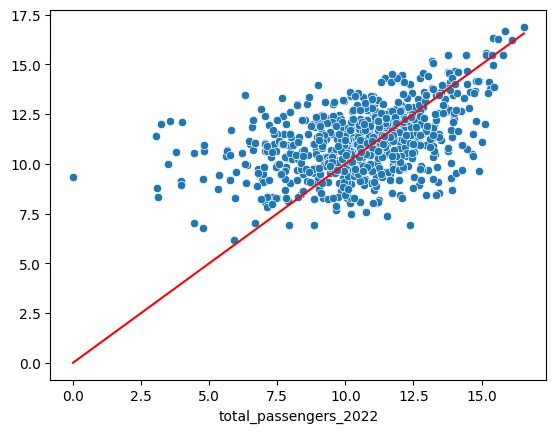

In [47]:
from sklearn.metrics import accuracy_score

best_k = knn_cv.best_params_['n_neighbors']
# Use the best hyperparameter and train the final model
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


sns.scatterplot(x=np.log(y_test), y=np.log(y_pred))
# draw identity line
plt.plot([np.min(np.log(y_test)), np.max(np.log(y_test))], [np.min(np.log(y_test)), np.max(np.log(y_test))], color='red')

In [48]:
# Compute metrics
model = 'KNN'
hyperparameters = {'k': best_k}
write_metrics_in_csv(y_pred, y_test, model, hyperparameters)

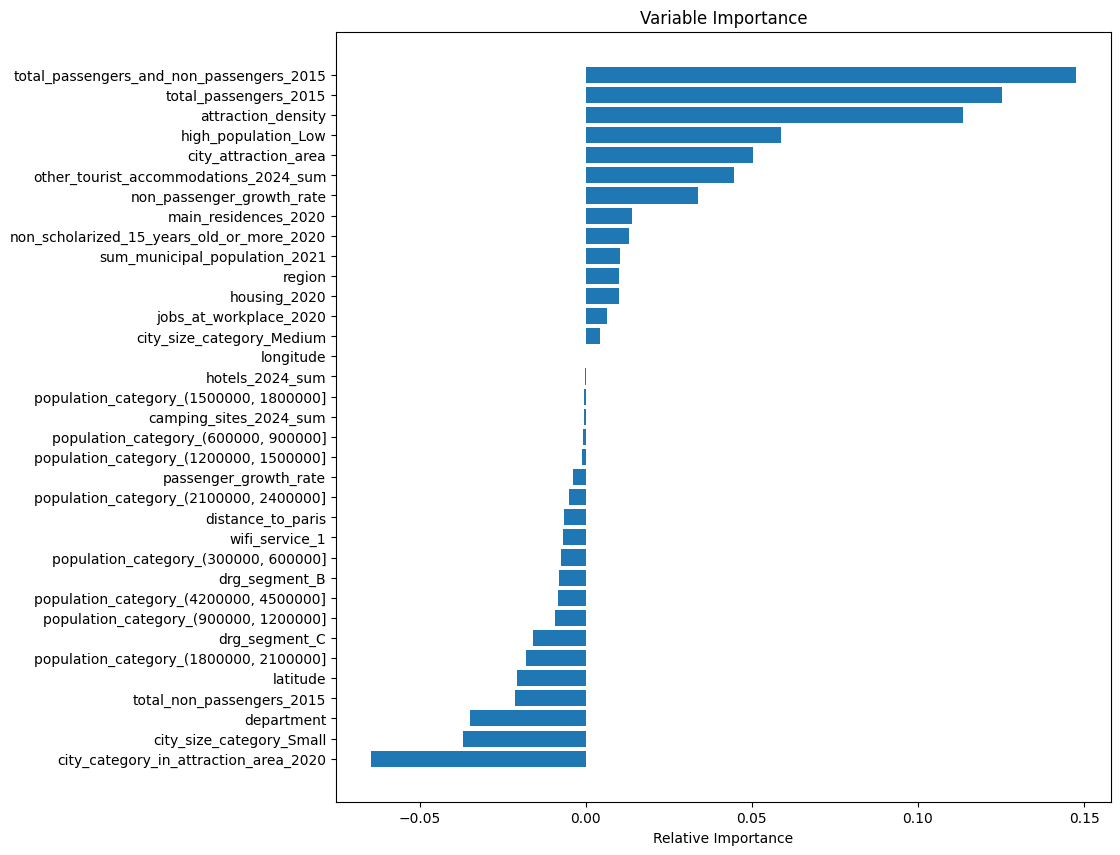

In [49]:
# Get feature importance

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(knn, X_test, y_test, n_repeats=30, random_state=42)
feature_importance = perm_importance.importances_mean
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [50]:
dataset.columns

Index(['total_passengers_2022', 'total_passengers_2015',
       'total_passengers_and_non_passengers_2015', 'city_attraction_area',
       'city_category_in_attraction_area_2020', 'department', 'region',
       'sum_municipal_population_2021',
       'non_scholarized_15_years_old_or_more_2020', 'main_residences_2020',
       'housing_2020', 'jobs_at_workplace_2020', 'hotels_2024_sum',
       'camping_sites_2024_sum', 'other_tourist_accommodations_2024_sum',
       'latitude', 'longitude', 'passenger_growth_rate', 'attraction_density',
       'total_non_passengers_2015', 'non_passenger_growth_rate',
       'distance_to_paris', 'drg_segment_B', 'drg_segment_C', 'wifi_service_1',
       'city_size_category_Medium', 'city_size_category_Small',
       'high_population_Low', 'population_category_(300000, 600000]',
       'population_category_(600000, 900000]',
       'population_category_(900000, 1200000]',
       'population_category_(1200000, 1500000]',
       'population_category_(1500000